In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/yelp_review_full.bin

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!mkdir fastText/build
!cd fastText/build && cmake .. && make -j && make install
!cd fastText && pip install .

In [ ]:
!pip install --upgrade pandas==1.3.4

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, plot_confusion_matrix
import fasttext
import spacy
from string import punctuation
from sklearn import metrics
import pickle as pkl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def process_text(text, nlp):
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if (token not in stopwords and token.text not in punctuation)])

def process_text_model(text, nlp, model):
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if (token not in stopwords and token.text not in punctuation and token.lemma_ in model.words)])

def text_preprocessing(x):
    nlp = spacy.load('en_core_web_trf', disable=["ner"])
    return x.apply(lambda text: process_text(text, nlp))

def text_preprocessing_model(x, model):
    nlp = spacy.load('en_core_web_trf', disable=["ner"])
    return x.apply(lambda text: process_text_model(text, nlp, model))

def convert_emotions(df):
    y = []
    for i in range(10):
        y.append((df.iloc[:,i] + df.iloc[:,i +10]) / 2)
    matrix = []
    for j in range(len(y[0])):
        row = []
        for i in range(10):
            row.append(y[i][j])
        matrix.append(row)
    return pd.DataFrame(matrix, columns=['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'])

def load_data(files=None):
    if files is None:
        files = ['train.xlsx', 'dev.xlsx', 'test.xlsx']
    data = []
    for file in files:
        df = pd.read_excel(file)
        df = df.dropna()
        x = text_preprocessing(df['text'])
        y = convert_emotions(df.iloc[:, 2:])
        data.append(x)
        data.append(y)
    return data

def load_dev_test(model, files=None):
    if files is None:
        files = ['dev.xlsx', 'test.xlsx']
    data = []
    for file in files:
        df = pd.read_excel(file)
        df = df.dropna()
        x = text_preprocessing_model(df['text'], model)
        y = convert_emotions(df.iloc[:, 2:])
        data.append(x)
        data.append(y)
    return data

def text_to_vector(model, x):
    return np.stack(x.apply(lambda txt: model.get_sentence_vector(txt)))

def retrive_loaded_data():
    with open('loaded_data.pickle', 'rb') as f:
        data = pkl.load(f)
    (x_train, y_train, x_dev, y_dev, x_test, y_test), (df_train, df_dev, df_test) = data 
    return x_train, y_train, x_dev, y_dev, x_test, y_test, df_train, df_dev, df_test

In [ ]:
import pickle as pkl

with open('processed_data.pickle', 'rb') as f:
    data = pkl.load(f)

x_test_vec, y_train, x_dev_vec, y_dev, x_train_vec, y_test = data 

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
import itertools

#param_grid = [{'C': [0.1,1,10,100],
#              'gamma': [0.1,1,10,100],
#              'kernel': ['rbf']}, 
#              {'C': [0.1,1,10,100],
#              'kernel': ['linear']},
#              {'C': [0.1,1,10,100],
#              'kernel': ['poly'],
#              'degree':[2,3,5]}]

param_grid = [{'splitter': ['best', 'random'],
              'max_depth': [None,1,2,3,4,5],
              'max_leaf_nodes': [None,2,4,8,16,32],
              'max_features': ['auto', 'log2', 'sqrt'],
              'random_state': [None],
              'min_samples_leaf': [1,2,3,4]}]


best_score = 0
best_params = None
best_model_i = 0

for sets_of_params in param_grid:
    keys, values = zip(*sets_of_params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    for permuatation in permutations_dicts:
        ml = DecisionTreeRegressor(**permuatation)
        moc = MultiOutputRegressor(ml).fit(x_train_vec, y_train)

        score = moc.score(x_dev_vec, y_dev)
        print('Validation score:', score, ' params:', permuatation)
        if score > best_score:
            best_score = score
            best_params = permuatation


print('Best validation score:', best_score, ' Best params:', best_params)

Validation score: -0.6291900287932414  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'random_state': None, 'min_samples_leaf': 1}
Validation score: -0.5729757299090906  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'random_state': None, 'min_samples_leaf': 2}
Validation score: -0.48180209927449785  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'random_state': None, 'min_samples_leaf': 3}
Validation score: -0.43456356934650187  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'random_state': None, 'min_samples_leaf': 4}
Validation score: -0.691544771615886  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_nodes': None, 'max_features': 'log2', 'random_state': None, 'min_samples_leaf': 1}
Validation score: -0.5253243283014999  params: {'splitter': 'best', 'max_depth': None, 'max_leaf_no

In [ ]:
ml = DecisionTreeRegressor(**best_params)
moc = MultiOutputRegressor(ml).fit(x_train_vec, y_train)

In [ ]:
moc.score(x_test_vec, y_test)

0.09582437563415894

In [ ]:
errors = []
y_pred=moc.predict(x_test_vec)
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_test.iloc[:, idx],y_pred[:, idx])
    errors.append(test_accuracy)

In [ ]:
import pickle as pkl
with open('decision_tree_regressor.pickle', 'wb') as f:
    pkl.dump(moc, f)

[0.16223773239503347,
 0.0817441655512845,
 0.023194593211140146,
 0.004628554681649244,
 0.03620333135282938,
 0.06954275245118124,
 0.08189711815559564,
 0.21792215515485325,
 0.2474431468078372,
 0.03343020658018536]

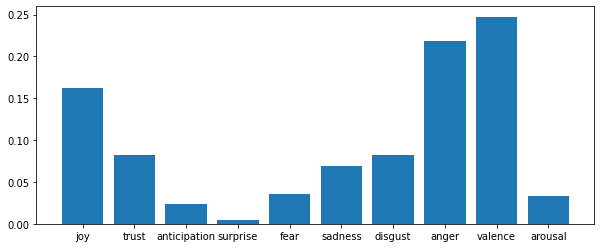

In [ ]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors